In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### load data

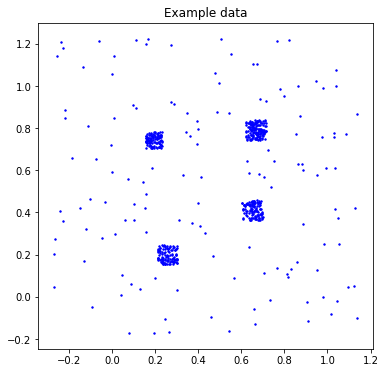

In [2]:
from scipy.io import loadmat

ori = loadmat('Data/Data5.mat')
n = len(ori['data'])
p = len(ori['data'][0])

for i in range(n):
    plt.scatter(ori['data'][i][0],ori['data'][i][1], s=2, c="blue")
plt.title("Example data")
plt.gcf().set_size_inches(6,6)
plt.show()

###  check the distribution of nearest neighbors

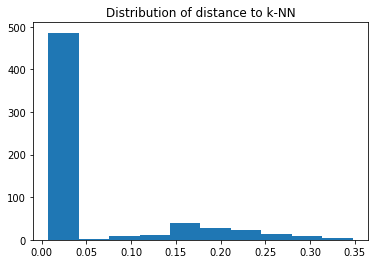

In [3]:
from scipy.spatial.distance import squareform, pdist

D = squareform(pdist(ori['data']))

test_flag = 1
list1 = []

if test_flag:
    D_sort = sort(D,1)
    k=7
    
    for i in range(len(D_sort)):
        list1.append( D_sort[i][k+1] )    
    dist_knn = array(list1)
    list1.clear()
    
    median_val = median(dist_knn)
    eps_val = median_val*median_val/2
    sigmaK = sqrt(2)*median_val
    
    plt.hist(dist_knn)
    plt.title('Distribution of distance to k-NN')
    plt.gcf().set_size_inches(6,4)
    plt.show()

### set parameters in model

In [4]:
eps_val=0.001
neigen=10        #undifine=0
flag_t=0
if flag_t:
    t=3

### eigendecomposition

In [5]:
def diffuse(D, eps_val, neigen, t):
    
    n=len(D[0])
    
    K=get_K(D, eps_val)
    
    v=get_v(K)
    
    A=get_A(K, v)    #symmetric graph Laplacian
    
    [psi, phi, eigenvals]=get_psiphi(A)    #eigenvectors,eigenvalues of Markov matrix

    X = get_X(eigenvals, neigen, psi, t)    #non-trivial diffusion coords

    
    return X, eigenvals, psi, phi

In [6]:
def get_K(D, eps_val):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-D[i][j]*D[i][j]/(4*eps_val)) )
    K = array(list1).reshape(n, n)
    
    return K

In [7]:
def get_v(K):
    list1=[]
    
    for i in range(n):
        list1.append( sqrt(sum(K[i])) )
    v = array(list1).reshape(n,1)
    
    return v

In [8]:
from scipy.sparse import csr_matrix

def get_A(K, v):
    list1=[]
    
    A = K/(v*v.T)
    threshold = 5e-6
    
    for i in range(n):
        for j in range(n):
            if A[i][j]>threshold:
                list1.append(1.)
            else: list1.append(0.)
    b = array(list1).reshape(n, n)
    
    A = csr_matrix(A*b, dtype=float)
    
    return A

In [9]:
from scipy.sparse.linalg import svds

def get_psiphi(A):
    list1=[]
    list2=[]
    
    [U, S, V] = svds(A,neigen+1)
    
    #print(U)
    #print(V)
    
    eigenvals = flip(S).reshape(neigen+1,1)
    for i in range(n): U[i]=flip(U[i])
    
    for i in range(n):
        for j in range(neigen+1):
            list1.append(U[i][j]/U[i][0])
            list2.append(U[i][j]*U[i][0])
    psi = array(list1).reshape(n, neigen+1) #right eigenvectors
    phi = array(list2).reshape(n, neigen+1) #left eigenvectors
    
    
    return [psi, phi, eigenvals]

In [10]:
def get_X(eigenvals, neigen, psi, t):
    list1=[]
    list2=[]
    list3=[]
    list4=[]
    
    
    if t is not 0:
        for i in range(n):
            for j in range(1, len(eigenvals)):
                list1.append( pow(eigenvals[j], t) )
        lambda_t = array(list1).reshape(n, len(eigenvals)-1)

        if neigen is 0:
            for i in range(len(eigenvals)):
                list2.append( lambda_t[0][i])/(lambda_t[0][0] )
            lam = array(list2)
            
            for i in range(len(eigenvals)):
                if lam[i]<0.05: list3.append(lam[i])
            neigen = min(list3)
            neigen = min(neigen, 50)
        
        for i in range(n):
            for j in range(neigen):
                list4.append(psi[i][j+1]*lambda_t[i][j])
        X = array(list4).reshape(n, neigen)
    else:
        for i in range(n):
            for j in range(1, len(eigenvals)):
                list1.append( eigenvals[j]/(1-eigenvals[j]) )
        lambda_multi = array(list1).reshape(n, len(eigenvals)-1)
        
        if neigen is 0:
            for i in range(len(eigenvals)):
                list2.append( lambda_multi[0][i])/(lambda_t[0][0] )
            lam = array(list2)
            
            for i in range(len(eigenvals)):
                if lam[i]<0.05: list3.append(lam[i])
            neigen = min(list3)
            neigen = min(neigen, 50)
        
        for i in range(n):
            for j in range(neigen):
                list4.append(psi[i][j+1]*lambda_multi[i][j])
        X = array(list4).reshape(n, neigen)
    

    return X

In [11]:
X, eigenvals, psi, phi = diffuse(D, eps_val, neigen, 0) #undifine t=0

### fall-off of eigenvalues

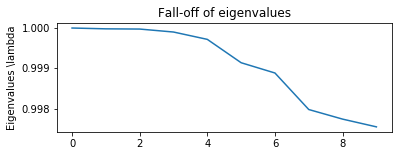

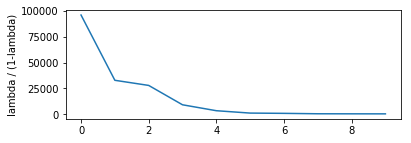

In [12]:
plt.plot(eigenvals[1:neigen+1])
plt.gcf().set_size_inches(6,2)
plt.ylabel('Eigenvalues \lambda')
plt.title('Fall-off of eigenvalues')
plt.show()

if flag_t:
    plt.plot(pow(eigenvals[1:neigen+1], t))
    plt.gcf().set_size_inches(6,2)
    plt.ylabel('\lambda^t')
    plt.show()
else:
    lambda_multi=eigenvals[1:neigen+1]/(1-eigenvals[1:neigen+1]) 
    plt.plot(lambda_multi)
    plt.gcf().set_size_inches(6,2)
    ylabel('lambda / (1-lambda)')
    plt.show()

### Diffusion map

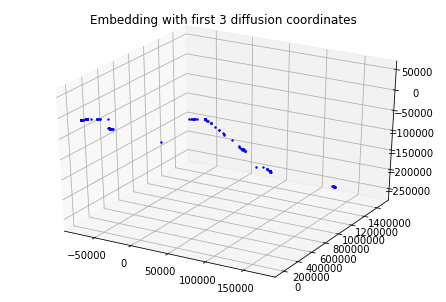

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
for i in range(len(X)):
    ax.scatter(X[i][0],X[i][1],X[i][2],s=2, c='b')
    
ax.set_title('Embedding with first 3 diffusion coordinates')
plt.show()

### diffusion k-means

In [14]:
k=5
Niter=100
epsilon=1e-3

list1=[]
for i in range(n):
    list1.append(phi[i][0])
phi0=array(list1).reshape(n,1)

In [15]:
from math import ceil
import random as rnd

def diffusion_kmeans(X, k, phi0, Niter, epsilon):
    
    n=len(X)
    d=len(X[0])
    aD=Inf

    for i in range(Niter): #Niter
        tmp_ind = rnd.sample(range(n), k)
        
        list1=[]
        for p in tmp_ind:
            for q in range(d):
                list1.append(X[p-1][q])
        c_0 = array(list1).reshape(k, d)
    
        idx, c, cindex, D, DX = distortionMinimization(X, phi0, k, c_0, 0, epsilon)

        if D<aD:
            aD=D
            aDX=DX
            a_idx=idx
            ac=c
    D=aD
    DX=aDX
    idx=a_idx
    C=ac
    
    return idx, C, D, DX

In [16]:
def distortionMinimization(X, phi0, k, c_0, DspFlag, epsilon):
    n=len(X)
    d=len(X[0])
    c=c_0
    oldD=Inf
    MaxIter=1000
    
    
    list1=[]
    list2=[]
    list3=[]
    
    for i in range(MaxIter): #MaxIter
        for j in range(k):
            for p in range(n):
                for q in range(d):
                    list1.append(X[p][q]-c[j][q])
            dX = (array(list1).reshape(n,d)).T    #dX=dX.T
            list1.clear()
            
            list2.append(sum(dX.conj()*dX,axis=0))
        DX = (array(list2).reshape(k,n)).T
        list2.clear()
        
        for j in range(n):
            list1.append(min(DX[j]))
            list2.append(argmin(DX[j])+1)
        Dtmp = array(list1).reshape(1,n)
        S = array(list2).reshape(n,1)
        
        list1.clear()
        list2.clear()
        
        ind=[]
        for j in range(k):
            for p in range(n):
                if S[p]==j+1: ind.append(p)
            if len(ind)==0:
                mx = max(Dtmp[0])
                m = argmax(Dtmp[0])
                S[m][0] = j+1
                Dtmp[0][m] = 0
            ind.clear()

        for j in range(k):
            for p in range(n):
                if S[p]==j+1: ind.append(p)
            for p in range(d):
                tempsum=0
                for q in ind:
                    tempsum += phi0[q][0]
                tempsum2=0
                for q in ind:
                    tempsum2 += phi0[q][0]*X[q][p]/tempsum
                list3.append(tempsum2)
            ind.clear()
        c = array(list3).reshape(k,d)
        
        list3.clear()
        
        D = dot(Dtmp, phi0)
        
        
        """
        #plot results
        
        for j in range(len(D)*len(D[0])):list3.append(Inf)
        oldD = array(list3).reshape(len(D), len(D[0]))
        
        list1.clear()
        list2.clear()
        list3.clear()
        """
        
        
        if (oldD-D)/D < epsilon: break
        oldD=D
        
        
    for j in range(k):
        for p in range(n):
            for q in range(d):
                list1.append(X[p][q]-c[j][q])
        dX = (array(list1).reshape(n,d)).T    #dX=dX.T
        list1.clear()
  
        list2.append(sum(dX.conj()*dX,axis=0))
        DX = array(list2).reshape(n,1)
        list2.clear()
            
        dummy = min(DX.T[0])
        list3.append( argmin(DX.T[0]) )
    cindex = array(list3).reshape(k,1)
    
    
    return S, c, cindex, D, DX

In [17]:
idx, C, ERR, DX = diffusion_kmeans(X, k, phi0, Niter, 0.001)

### k-means labeling

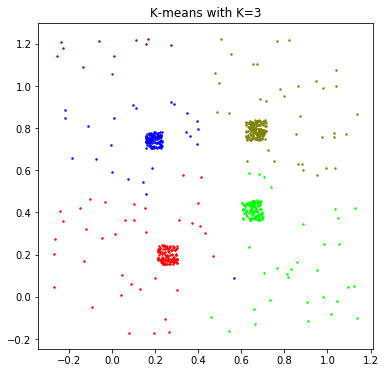

In [18]:
cmap = cm.brg
norm = Normalize(1, k)

for i in range(n):
    plt.scatter(ori['data'][i][0], ori['data'][i][1], s=2, c=cmap(norm(idx[i])) )

plt.title('K-means with K=3')
plt.gcf().set_size_inches(6,6)
plt.show()